# LDA Analysis on White Wine Reviews:

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction import text
from gensim import corpora, models, matutils
import nltk
import re
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
white_clean = pd.read_csv('/Users/divyasusarla/Desktop/DSI-SF-2-divyasusarla/Capstone/Clean_Data/white_reviews_clean.csv', encoding='utf-8')

In [3]:
del white_clean['Unnamed: 0']
white_clean.dropna(inplace=True)

In [24]:
white_clean.shape

(96407, 4)

# Create stopwords:

In [9]:
def identify_stop_words(data):
    white_clean['word_check'] = white_clean.white_review.map(
        lambda x: re.findall(r'\w*\d\w*', x) if len(re.findall(r'\w*\d\w*', x))>0 else np.nan)
    corpus_words = [word for sent in white_clean.word_check[~white_clean.word_check.isnull()] for word in sent]
    corpus_words = list(set(corpus_words))
    nltk_stop = list(stopwords.words('english'))
    white_clean.drop('word_check',axis=1,inplace=True)
    my_stop_words = nltk_stop + corpus_words
    return my_stop_words

In [10]:
my_stop_words = identify_stop_words(white_clean.white_review) + ['great', 'wine', 'nice', 'needs', 'time', 'white', 
                                                            'good', 'nose', 'bottle', 'palate', 'little', 
                                                             'best', 'wines', 'years', 'colour', 'color', 'excellent', 
                                                             'price', 'point', 'mouth', 'feel', 'value', 'lovely', 
                                                             'another', 'easy', 'drink', 'drinking', 'birthday', 'wife', 
                                                             'day', 'amongst', 'across', 'hours', 'hour', 'year', 
                                                             'wonderfull', 'amazing', 'well', 'one', 'second', 'new', 
                                                             'dinner', 'perfect', 'wow', 'buy', 'nicely', 
                                                             'beautifully', 'ever', 'tasted', 'sauv', 'blanc', 
                                                                'sauvignon', 'blanc', 'pinot', 'grigio']

In [11]:
review = white_clean['white_review']

# Visualize the spread of words by count and percentile:

In [12]:
vectorizer = CountVectorizer(stop_words= my_stop_words, ngram_range=(2,2))
X = vectorizer.fit_transform(review)
X = X.todense()

In [13]:
# words = pd.DataFrame(X, columns=vectorizer.get_feature_names())
# word_count = words.sum(axis=0).reset_index()
# word_count.columns = ['words','counts']
# word_count.sort_values('counts', ascending=False, inplace=True)
# word_count.head(50).plot(x='words', y='counts', kind='bar', figsize=(18,7))

In [14]:
# word_count_percentiles = pd.DataFrame({
#         'percentile':np.arange(1,100,1),
#         'word_count':np.percentile(word_count.counts, np.arange(1., 100., 1))
#     })
# word_count_percentiles.plot(x='percentile', y='word_count', kind='bar', figsize=(18,7))

# Set up LDA

In [16]:
# use the counter option to get the most common words. 
from collections import Counter
# Count the most common tokens 
summaries = "".join(white_clean['white_review'])
vocab_summaries = vectorizer.build_analyzer()(summaries)
white_vocab = Counter(vocab_summaries).most_common(5000)
white_vocab = dict(white_vocab)

vectorizer2 = CountVectorizer(vocabulary=white_vocab.keys(), stop_words= my_stop_words, ngram_range=(2,2))
X2 = vectorizer2.fit_transform(review)
X2.shape
X2.todense()

vocab2 = {v: k for k, v in vectorizer2.vocabulary_.iteritems()}

lda2 = models.LdaModel(
   matutils.Sparse2Corpus(X2, documents_columns=False),
   num_topics  =  25,
   passes      =  25,
   iterations = 2500,
   id2word     =  vocab2,
   eval_every = 100,
   chunksize = 2000
)

In [17]:
lda2.print_topics(num_topics=25, num_words=10)

[(0,
  u'0.041*long finish + 0.040*green apple + 0.037*medium plus + 0.028*semi dry + 0.027*acidity long + 0.026*orange blossom + 0.026*acidity finish + 0.025*dry sweet + 0.022*buttery finish + 0.016*clean fresh'),
 (1,
  u'0.066*light crisp + 0.061*medium acidity + 0.054*fruity sweet + 0.040*crisp dry + 0.040*full body + 0.028*dry medium + 0.021*lime zest + 0.019*creamy texture + 0.018*oak vanilla + 0.016*sweet finish'),
 (2,
  u'0.052*crisp clean + 0.043*fruity dry + 0.032*sweet fruity + 0.027*med body + 0.027*fruit notes + 0.020*citrus peach + 0.017*fruity fresh + 0.014*ever tasted + 0.014*med finish + 0.014*toasted oak'),
 (3,
  u'0.062*light refreshing + 0.058*light fruity + 0.056*green apples + 0.023*hint oak + 0.021*lemon green + 0.018*fruity taste + 0.017*dry slightly + 0.015*bone dry + 0.014*fruity flavor + 0.013*fruit apple'),
 (4,
  u'0.048*sauv blanc + 0.036*crisp fruity + 0.032*peach apricot + 0.025*apple peach + 0.024*cut grass + 0.022*stone fruit + 0.021*perfectly balanc

## Get the probabilities by topic into a dataframe:

Below I am turning my documents into a format that can pass through the get_document_topics function, but I am also checking to see how many documents I have that contain data.

In [18]:
bow = []
blank_documents = 0
for document in X2.toarray():
    single_document = []
    for token_id, token_count in enumerate(document):
        
        if token_count > 0:
              single_document.append((token_id, token_count))
            
    if len(single_document)>0:
        bow.append(single_document)
    else:
        blank_documents += 1
        bow.append([])

In [19]:
len(bow), blank_documents

(96407, 31327)

In [20]:
lda2.get_document_topics(bow[6])

[(0, 0.013333333333333334),
 (1, 0.013333333333333334),
 (2, 0.013333333333333334),
 (3, 0.013333333333333334),
 (4, 0.013333333333333334),
 (5, 0.013333333333333334),
 (6, 0.013333333333333334),
 (7, 0.013333333333333334),
 (8, 0.013333333333333334),
 (9, 0.013333333333333334),
 (10, 0.013333333333333334),
 (11, 0.013333333333333334),
 (12, 0.013333333333333334),
 (13, 0.013333333333333334),
 (14, 0.013333333333333334),
 (15, 0.013333333333333334),
 (16, 0.34666666666668405),
 (17, 0.013333333333333334),
 (18, 0.013333333333333334),
 (19, 0.013333333333333334),
 (20, 0.013333333333333334),
 (21, 0.013333333333333334),
 (22, 0.013333333333333334),
 (23, 0.013333333333333334),
 (24, 0.3466666666666493)]

In [21]:
topic_proba =lda2.get_document_topics(bow)

In [22]:
topic_df = np.zeros((len(topic_proba), 25))
for rowid, tp in enumerate(topic_proba):
    for colid, p in tp:
        topic_df[rowid, colid] = p
        
topic_df = pd.DataFrame(topic_df, columns=['t'+str(i+1) for i in range(topic_df.shape[1])])

In [23]:
topic_df.head(5)

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25
0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.510000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
1,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.680000,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333
2,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.520000,0.020000,0.020000,0.020000,0.020000
3,0.000000,0.000000,0.208000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.208000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.680000,0.013333,0.013333,0.013333


# Further analysis into the topics:

In [25]:
def get_documents_by_topic(topic='t1', threashold = .65):
    orig_df = pd.read_csv("../Clean_Data/white_reviews_clean.csv")
    orig_df = orig_df.dropna()  
    return orig_df[orig_df.index.isin(topic_df[topic_df[topic] > threashold].index)]['white_review']

def get_top_feature_counts(df, limit = 10, vectorizer = vectorizer):

    X = vectorizer.fit_transform(df)

    tokens = pd.DataFrame()
    stats_df = pd.DataFrame(X.toarray(), columns=vectorizer.vocabulary_)
    tokens['tokens'] = stats_df.columns 
    tokens['count'] = stats_df.T.sum()
    tokens = tokens.set_index('tokens')
    return tokens.sort('count', ascending=False).head(limit)

In [26]:
topic_df['max_prob'] =  topic_df.apply(np.argmax, axis=1)

In [27]:
topic_df['unique_probs'] = topic_df.apply(lambda x: len(np.unique(x[0:25])), axis=1)
topic_df.head(10)

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,...,t18,t19,t20,t21,t22,t23,t24,t25,max_prob,unique_probs
0,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,t17,3
1,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.680000,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,t9,2
2,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.020000,0.020000,0.020000,0.520000,0.020000,0.020000,0.020000,0.020000,t21,2
3,0.000000,0.000000,0.208000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.208000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,t13,4
4,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.680000,0.013333,0.013333,0.013333,t22,5
5,0.000000,0.000000,0.000000,0.208000,0.000000,0.000000,0.000000,0.000000,0.208000,0.000000,...,0.000000,0.000000,0.208000,0.000000,0.000000,0.000000,0.000000,0.000000,t4,5
6,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.346667,t17,3
7,0.000000,0.000000,0.000000,0.208000,0.000000,0.000000,0.000000,0.000000,0.208000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,t11,4
8,0.000000,0.000000,0.173333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.673333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,t19,3
9,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.680000,0.013333,t24,2


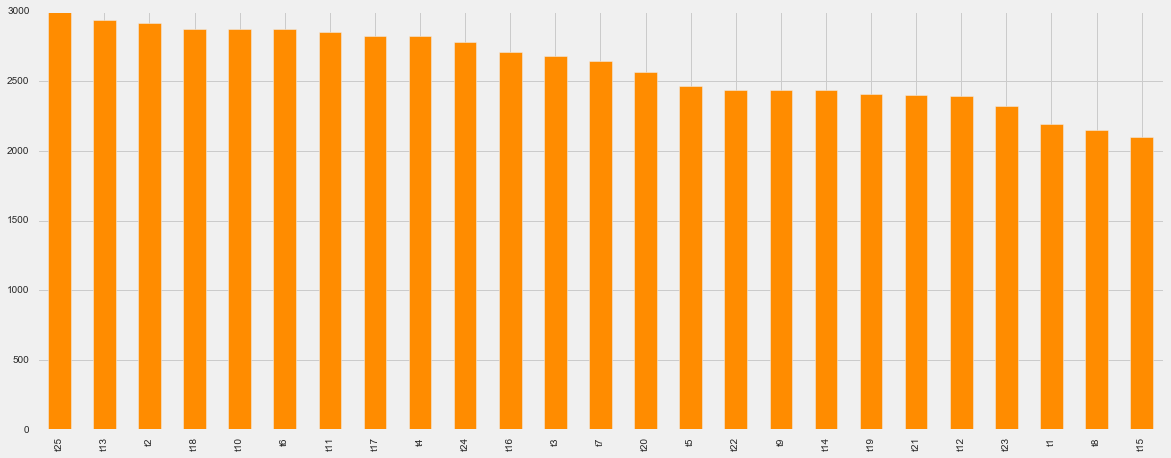

In [28]:
# Distribution of topic membership:
topic_df[topic_df.unique_probs>1].max_prob.value_counts().plot(kind='bar', figsize=(18,7), color='darkorange')

In [30]:
# docs topics are the documents in the topic paramter
docs_topics = get_documents_by_topic('t25', .65)

# get df of top word counts by df
get_top_feature_counts(docs_topics, limit = 10)

/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,count
tokens,
winds blowing,45.0
aged american,33.0
lasting overall,23.0
dry slightly,22.0
sour refreshing,22.0
yellow straw,21.0
colder might,21.0
extra chilled,20.0
apple cider,19.0


# Create Data Frame of topic probabilities and the reviews

In [31]:
whitewines_topics = pd.concat((white_clean, topic_df), axis=1)
whitewines_topics.head()

,review_index,white_wine,white_user,white_review,t1,t2,t3,t4,t5,t6,...,t18,t19,t20,t21,t22,t23,t24,t25,max_prob,unique_probs
0,0.0,Chardonnay Hudson Vineyard,Alyssa Rapp,Excellently balanced chard-meyer lemon and nec...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,t17,3.0
1,1.0,Chardonnay Hudson Vineyard,Sam Hovland,$63. Glazer's distributes. Very high end site....,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,t9,2.0
2,2.0,Chardonnay Hudson Vineyard,Jon Walheim,"High acid, drank pre-release. Will wait a yea...",0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.020000,0.020000,0.020000,0.520000,0.020000,0.020000,0.020000,0.020000,t21,2.0
3,3.0,Chardonnay Hudson Vineyard,Jonathan Williams,Has a extract texture. Slightly nutty almost l...,0.000000,0.000000,0.208000,0.000000,0.000000,0.000000,...,0.208000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,t13,4.0
4,4.0,Chardonnay Hudson Vineyard,Glenn Adams,Very acidic. Had June 2013. Malolactic. Nothin...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,...,0.013333,0.013333,0.013333,0.013333,0.680000,0.013333,0.013333,0.013333,t22,5.0


In [32]:
white_details = pd.read_csv('/Users/divyasusarla/Desktop/DSI-SF-2-divyasusarla/Capstone/Clean_Data/white_wine_details_clean.csv', encoding='utf-8')

In [33]:
del white_details['Unnamed: 0']
white_details.head()

,wine_index,white_wine,white_wineries,white_regions,white_countries,white_avg_wine_ratings,white_avg_price,vintage_year
0,0,Chardonnay Hudson Vineyard,Patz & Hall,Sonoma County,United States,4.0,54.99,NaN
1,1,Meursault-Blagny,Thierry et Pascale Matrot,C\xf4te de Beaune,France,3.9,47.68,NaN
2,2,Domaine de La Chapelle Les Grands Climats Poui...,Catherine et Pascal Rollet,Bourgogne,France,4.1,29.97,2013.0
3,3,Sauvignon Blanc 2014,Ancient Peaks,California,United States,4.0,12.98,2014.0
4,4,"[u""Champion's Lot Riva Ranch Chardonnay 2013""]",Wente,Livermore Valley,United States,3.8,24.98,2013.0


In [34]:
print white_details.shape, whitewines_topics.shape

(9899, 8) (97350, 31)


In [35]:
print len(white_details.white_wine.unique())
print len(whitewines_topics.white_wine.unique())

7025
4311


In [36]:
wine_name_counts = white_details.white_wine.value_counts().reset_index()
wine_name_counts.columns = ['white_wine','label_count']

In [37]:
white_details[white_details.white_wine.isin(wine_name_counts[wine_name_counts.label_count == 1].white_wine)].shape

(6395, 8)

In [38]:
unique_white_details = white_details[white_details.white_wine.isin(wine_name_counts[wine_name_counts.label_count == 1].white_wine)]

In [39]:
white_df = pd.merge(unique_white_details, whitewines_topics, on='white_wine')
white_df.shape

(48128, 38)

In [40]:
white_df.head()

,wine_index,white_wine,white_wineries,white_regions,white_countries,white_avg_wine_ratings,white_avg_price,vintage_year,review_index,white_user,...,t18,t19,t20,t21,t22,t23,t24,t25,max_prob,unique_probs
0,0,Chardonnay Hudson Vineyard,Patz & Hall,Sonoma County,United States,4.0,54.99,NaN,0.0,Alyssa Rapp,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,t17,3.0
1,0,Chardonnay Hudson Vineyard,Patz & Hall,Sonoma County,United States,4.0,54.99,NaN,1.0,Sam Hovland,...,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,0.013333,t9,2.0
2,0,Chardonnay Hudson Vineyard,Patz & Hall,Sonoma County,United States,4.0,54.99,NaN,2.0,Jon Walheim,...,0.020000,0.020000,0.020000,0.520000,0.020000,0.020000,0.020000,0.020000,t21,2.0
3,0,Chardonnay Hudson Vineyard,Patz & Hall,Sonoma County,United States,4.0,54.99,NaN,3.0,Jonathan Williams,...,0.208000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,t13,4.0
4,0,Chardonnay Hudson Vineyard,Patz & Hall,Sonoma County,United States,4.0,54.99,NaN,4.0,Glenn Adams,...,0.013333,0.013333,0.013333,0.013333,0.680000,0.013333,0.013333,0.013333,t22,5.0


In [41]:
white_df.wine_index.count()

48128

In [43]:
white_df.to_csv(path_or_buf='/Users/divyasusarla/Desktop/DSI-SF-2-divyasusarla/Capstone/LDA_analysis/white_formodel', encoding='utf8')